This notebook includes our final modeling which includes our baseline spatial mean model and backwards selection model. It also includes the data transformation and residual plots of our models.

In [1]:
import os 
import numpy as np
import pandas as pd 
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from patsy import dmatrices
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

C:\Users\ashmj\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


`od_final.csv` is included in the `Reproducible` folder.

In [6]:
od = pd.read_csv('od_final.csv')
od = od.drop([ 'FIPS',  'State', 'Region', 'Division', 'Overdose_Deaths', 'Overdose_Pop',
              'Pct_Majority_Income_to_Housing', 'Pct_Child_Free_Lunch', 
              'Premature_Deaths', 'Violent_Crime_Rate_per_100k', 
              'HIV_Rate_per_100k','Prev_Spatial_Max', 'Prev_Spatial_Mean', 'Spatial_Max'], axis=1)
od = od.dropna()
od_model = od.reset_index(drop=True)
od_model.columns

Index(['Year', 'County', 'Overdose_Rate_per_100k', 'Population',
       'Pct_Age_lt_18', 'Pct_Age_gte_65', 'Pct_Black', 'Pct_Native',
       'Pct_Asian', 'Pct_Pacific_Islander', 'Pct_Hispanic',
       'Pct_Not_Prof_in_Eng', 'Pct_Female', 'Pct_Rural', 'Pct_Diabetes',
       'Potential_Years_Lost', 'Pct_Low_Weight_Births', 'Pct_Smokers',
       'Pct_Adults_Obsese', 'Pct_Excessive_Drinking', 'Pct_DUI_Deaths',
       'Teen_Birth_Rate_per_100k', 'Pct_Uninsured', 'PrimCarePhys_per_100k',
       'Pct_HS_Grad', 'Pct_College_Edu', 'Pct_Children_in_Poverty',
       'Pct_Child_in_1ParentHH', 'Opioid_Disp_Rate_per_100k', 'Pct_Unemployed',
       'Pct_Poverty', 'Median_HHI', 'Jail_Pop', 'Urbanicity', 'Spatial_Mean'],
      dtype='object')

# Baseline Model with Spatial_Mean

## Baseline model without transforming response variable Overdose_Rate_per_100k

In [3]:
y, X = dmatrices("Overdose_Rate_per_100k ~ Spatial_Mean", 
                 data=od_model, return_type='dataframe')
y = np.log(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=30)

In [56]:
mod = sm.OLS(y_train, x_train)
res = mod.fit()
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     Overdose_Rate_per_100k   R-squared:                       0.460
Model:                                OLS   Adj. R-squared:                  0.460
Method:                     Least Squares   F-statistic:                     4882.
Date:                    Fri, 29 Apr 2022   Prob (F-statistic):               0.00
Time:                            17:07:01   Log-Likelihood:                -3060.6
No. Observations:                    5727   AIC:                             6125.
Df Residuals:                        5725   BIC:                             6139.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercep

In [57]:
y_test_pred = res.predict(x_test)
print('test R2:', r2_score(y_test, y_test_pred))
print('test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred)))

test R2: 0.42953658694089203
test RMSE: 0.4153207568570135


## Baseline model with log-transformed response variable Overdose_Rate_per_100k

`od_final_transformed.csv` can be found in `Reproducible` folder

In [8]:
od = pd.read_csv('od_final_transformed.csv')

#now we drop all the na values 
od_spatmean= od[['Spatial_Mean', 'log_Overdose_Rate_per_100k']]
od_spatmean = od_spatmean.dropna()
od_spatmean = od_spatmean.reset_index(drop=True)
od_spatmean

,Spatial_Mean,log_Overdose_Rate_per_100k
0,21.667119,2.553630
1,17.854349,2.475265
2,34.421638,2.519051
3,15.905439,2.735118
4,13.108417,3.737676
...,...,...
8595,29.180797,3.123236
8596,28.667630,3.173104
8597,20.006112,3.097410
8598,10.325017,3.211128


In [10]:
y, X = dmatrices("log_Overdose_Rate_per_100k ~ Spatial_Mean", 
                 data=od_spatmean, return_type='dataframe')
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=30)

#this is just with the spatial mean component 
mod = sm.OLS(y_train, x_train)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                                OLS Regression Results                                
Dep. Variable:     log_Overdose_Rate_per_100k   R-squared:                       0.451
Model:                                    OLS   Adj. R-squared:                  0.451
Method:                         Least Squares   F-statistic:                     5298.
Date:                        Tue, 03 May 2022   Prob (F-statistic):               0.00
Time:                                11:07:28   Log-Likelihood:                -3459.3
No. Observations:                        6450   AIC:                             6923.
Df Residuals:                            6448   BIC:                             6936.
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

In [11]:
# Getting RMSE
y_test_pred = res.predict(x_test)
np.sqrt(mean_squared_error(y_test, y_test_pred))

0.4074393195766386

In [12]:
od_spatmean['log_Overdose_Rate_per_100k'].describe()

count    8600.000000
mean        3.047718
std         0.555935
min         0.802774
25%         2.662734
50%         3.028552
75%         3.423273
max         5.144206
Name: log_Overdose_Rate_per_100k, dtype: float64

# Backwards Feature Selection

In [61]:
train_rmse_list = []
test_rmse_list = []
best_features = []
n_features_list  = []
cv_round_list = []
lr = LinearRegression()

y = od_model[['Overdose_Rate_per_100k']]
X_int = od_model.drop('Overdose_Rate_per_100k', axis=1)
# create intercept term
X_int.insert(0, 'Intercept', 1)

# Create X array
X = np.array(X_int)
# Log y variable
y = np.array(np.log(y))
X_columns = X_int.columns

cv_round = 0

# Perform 5-fold cross-validation:
# For each train-test split, do a cross-validated backwards selection
kf = KFold(n_splits=5, random_state=0, shuffle=True)
for train_index, test_index in kf.split(od_model):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cv_round = cv_round + 1 
    
    # For this train-test split
    # Create models with 1 to 32 variables using backwards selection
    for i in range(1, od_model.shape[1]):
        
        sfs = SequentialFeatureSelector(lr, n_features_to_select=i, 
                                        direction='backward', scoring='neg_mean_squared_error', 
                                        cv = 5)
        sfs.fit(X_train, y_train)

        best_cols = sfs.get_support()
        best_cols = [i for i, x in enumerate(best_cols) if x]
        best_cols = X_columns[best_cols].tolist()
        best_features.append(best_cols)

        X_subset = np.array(X_int[best_cols]).reshape(od_model.shape[0], len(best_cols))
        X_subtrain = X_subset[train_index]
        X_subtest = X_subset[test_index]
        
        # Get training RMSE
        lr.fit(X_subtrain, y_train)
        yhat_train = lr.predict(X_subtrain)
        train_rmse = np.sqrt(mean_squared_error(y_train, yhat_train))
        train_rmse_list.append(train_rmse)
        
        # Get test RMSE
        yhat_test = lr.predict(X_subtest)
        test_rmse = np.sqrt(mean_squared_error(y_test, yhat_test))
        test_rmse_list.append(test_rmse)
        
        n_features_list.append(i)
        cv_round_list.append(cv_round)

best_features_naive = best_features.copy() 
score_board = pd.DataFrame(train_rmse_list, columns=['train_rmse'])
score_board['test_rmse'] = test_rmse_list
score_board.insert(0, 'n_features', n_features_list)
score_board.insert(1, 'best_features', best_features)
score_board.insert(0, 'cv_round', cv_round_list)
score_board_naive = score_board.copy()
score_board_naive

,cv_round,n_features,best_features,train_rmse,test_rmse
0,1,1,[Spatial_Mean],0.410837,0.423830
1,1,2,"[Potential_Years_Lost, Spatial_Mean]",0.380531,0.397036
2,1,3,"[Potential_Years_Lost, Pct_Uninsured, Spatial_...",0.367959,0.381001
3,1,4,"[Pct_Age_lt_18, Potential_Years_Lost, Pct_Unin...",0.359169,0.370465
4,1,5,"[Pct_Age_lt_18, Potential_Years_Lost, Pct_Unin...",0.353845,0.365988
...,...,...,...,...,...
155,5,28,"[Intercept, Population, Pct_Age_lt_18, Pct_Bla...",0.343444,0.336617
156,5,29,"[Intercept, Population, Pct_Age_lt_18, Pct_Bla...",0.343350,0.336612
157,5,30,"[Intercept, Population, Pct_Age_lt_18, Pct_Bla...",0.343110,0.336654
158,5,31,"[Intercept, Population, Pct_Age_lt_18, Pct_Bla...",0.343098,0.336752


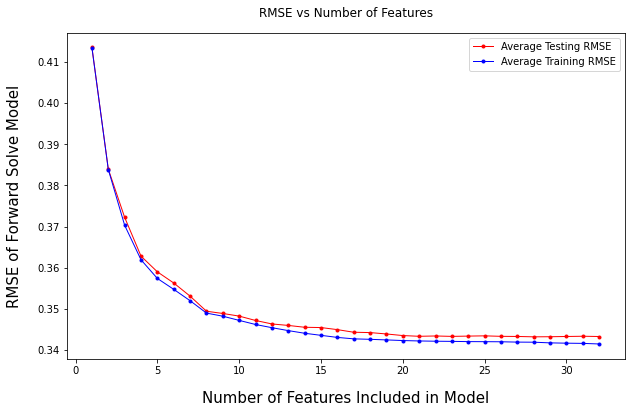

In [63]:
# Plot Average RMSE against the different number of features
plt.figure(figsize=(10,6))
plt.plot(score_naive_means['n_features'], score_naive_means['test_rmse'], color="red", label="Average Testing RMSE", linewidth=1, marker='.')
plt.plot(score_naive_means['n_features'], score_naive_means['train_rmse'], color="blue", label="Average Training RMSE", linewidth=1, marker='.')

plt.title("RMSE vs Number of Features", y=1.03)
plt.xlabel("Number of Features Included in Model", fontsize=15, labelpad=15)
plt.ylabel("RMSE of Backward Selection Models", fontsize=15, labelpad=15)
plt.legend()
plt.show()  

8 seems to be the best number of predictors to include in our variable. So let's choose the model with 8 features.

In [4]:
y, X = dmatrices("Overdose_Rate_per_100k ~ Pct_Age_lt_18 + Pct_Black + Potential_Years_Lost + Pct_Uninsured +\
                 PrimCarePhys_per_100k + Pct_Child_in_1ParentHH +  Pct_Poverty + Spatial_Mean", 
                 data=od_model, return_type='dataframe')
y = np.log(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=30)

mod = sm.OLS(y_train, x_train)
res = mod.fit()
print(res.summary())


                              OLS Regression Results                              
Dep. Variable:     Overdose_Rate_per_100k   R-squared:                       0.614
Model:                                OLS   Adj. R-squared:                  0.613
Method:                     Least Squares   F-statistic:                     1136.
Date:                    Sun, 01 May 2022   Prob (F-statistic):               0.00
Time:                            13:52:24   Log-Likelihood:                -2101.3
No. Observations:                    5727   AIC:                             4221.
Df Residuals:                        5718   BIC:                             4281.
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

## Explore residuals 

Here we explore residuals to determine the data transformations we should conduct.

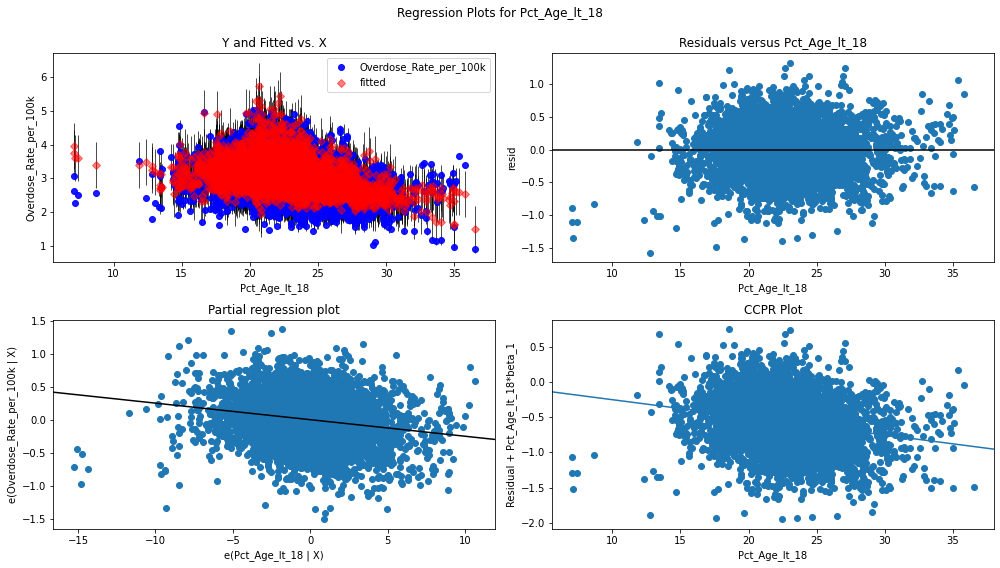

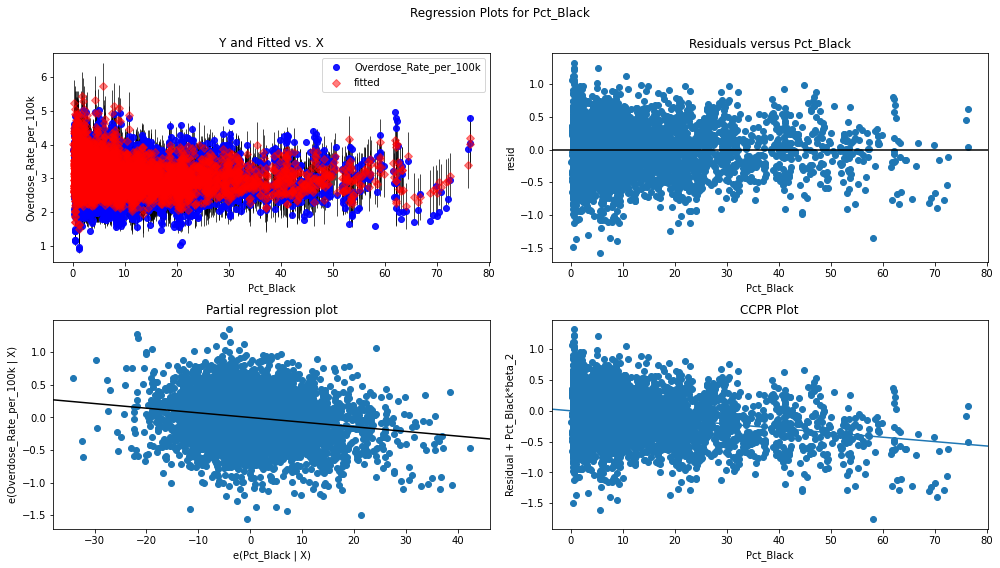

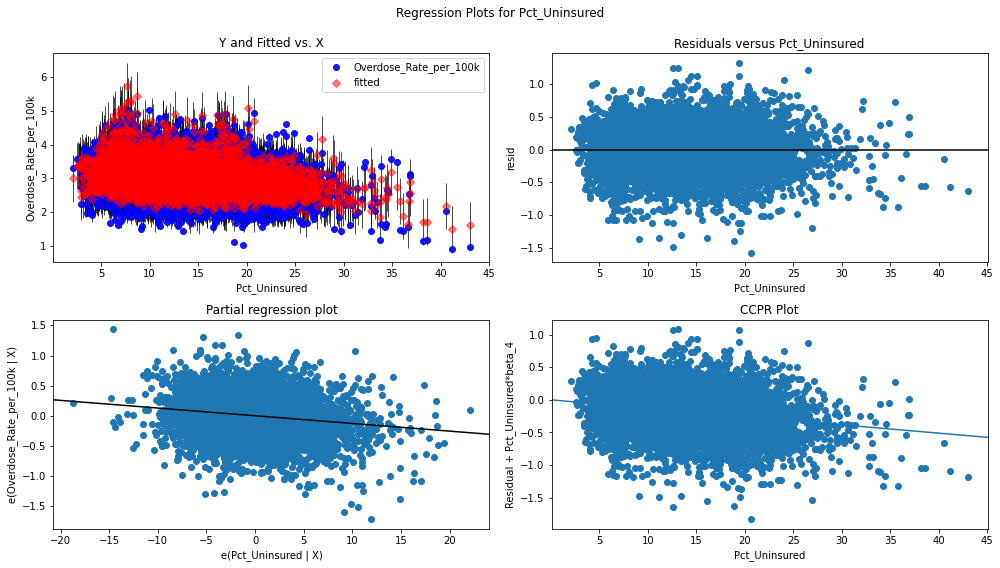

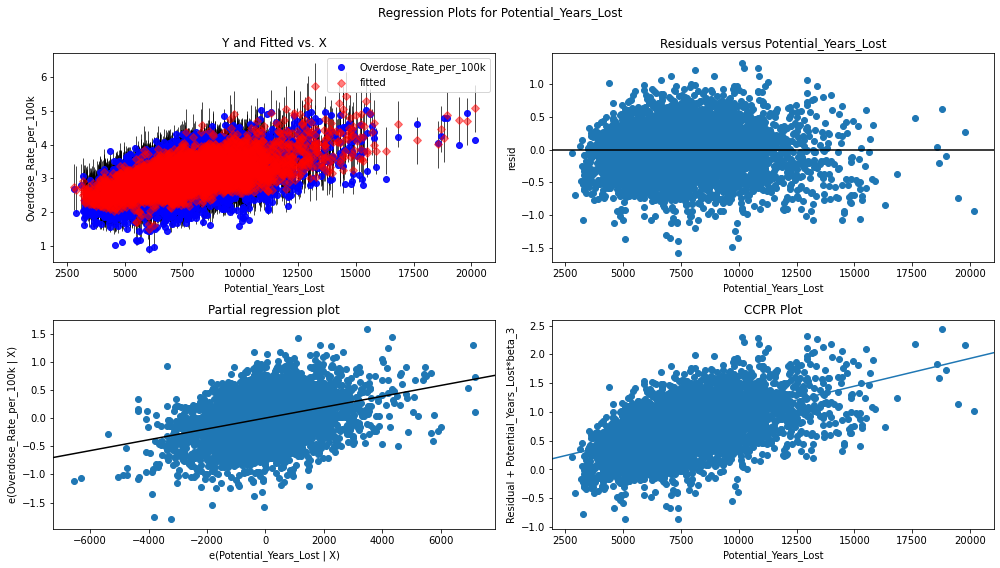

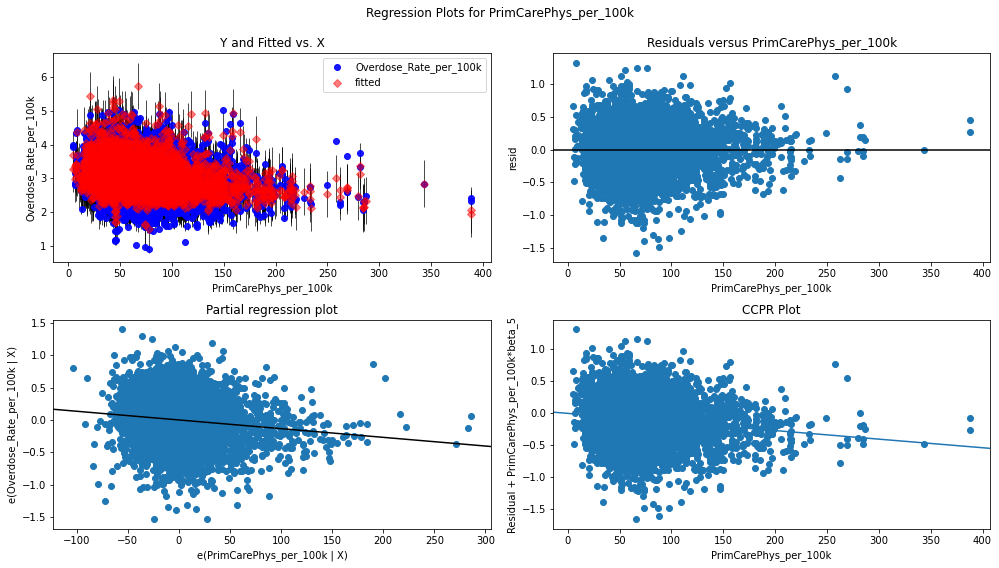

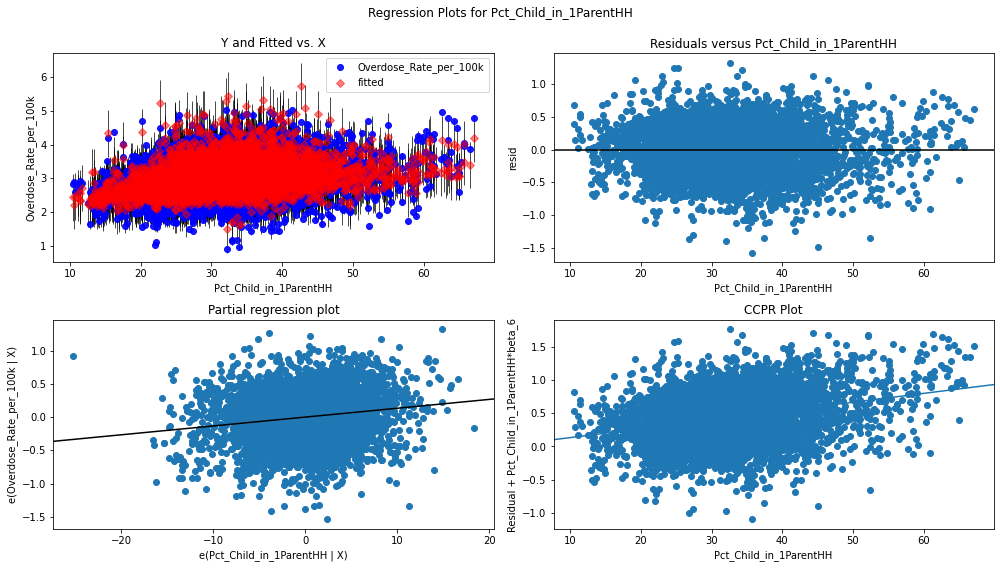

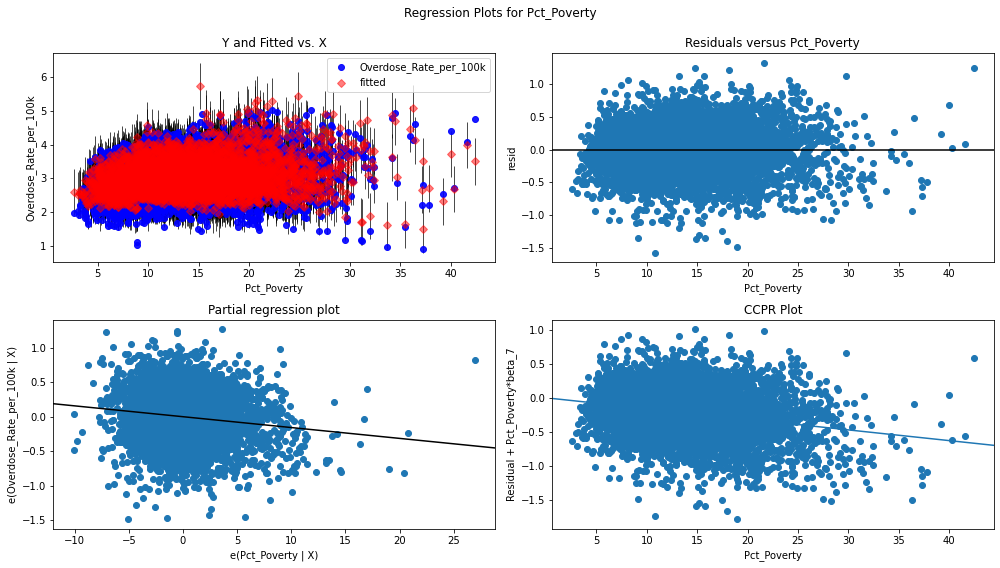

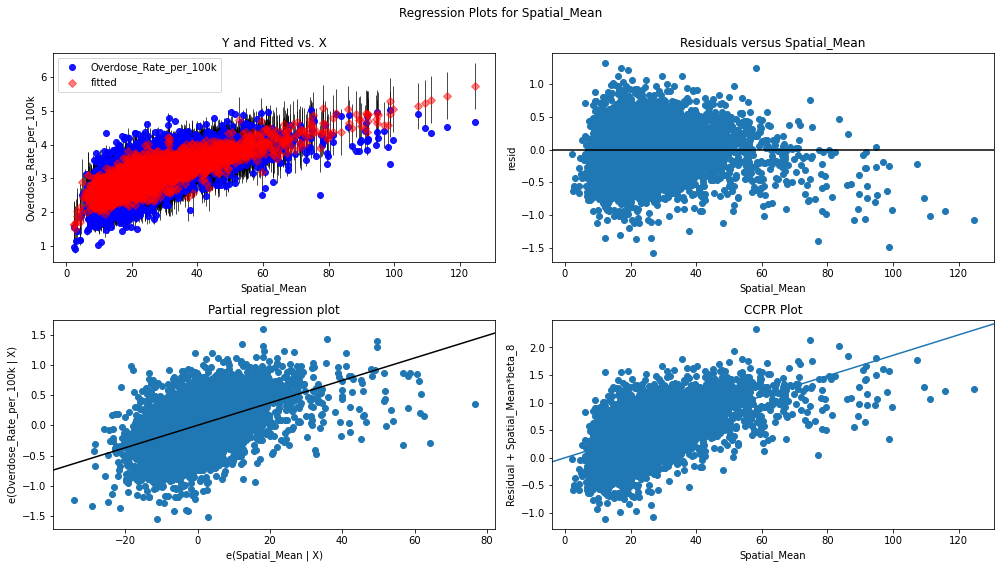

In [5]:
### Residual analysis with best subset 
# plot residuals
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

best_sub = ['Pct_Age_lt_18', 'Pct_Black', 'Pct_Uninsured', 'Potential_Years_Lost', 
            'PrimCarePhys_per_100k', 'Pct_Child_in_1ParentHH', 'Pct_Poverty', 'Spatial_Mean']
for i in best_sub: 
    fig = plt.figure(figsize=(14, 8))
    fig = sm.graphics.plot_regress_exog(res, i, fig=fig)

### Trying Transformations

The residuals that we decided to transform are `Pct_Black`, `PrimCarePhys_per_100k`, and `Spatial_Mean`.
* `Pct_Black` seems slightly skewed and slightly cone-shaped.
* `PrimCarePhys_per_100k` seems skewed and cone-shaped.
* For `Spatial_Mean`, we notice that for higher values, we often get negative residuals.


In [39]:
od_model['log_Pct_Black'] = np.log(od_model['Pct_Black']+1)
od_model['log_PrimCarePhys_per_100k'] = np.log(od_model['PrimCarePhys_per_100k'])
od_model['log_Spatial_Mean'] = np.log(od_model['Spatial_Mean'])
od_model

,Overdose_Rate_per_100k,Population,Pct_Age_lt_18,Pct_Age_gte_65,Pct_Black,Pct_Native,Pct_Asian,Pct_Pacific_Islander,Pct_Hispanic,Pct_Not_Prof_in_Eng,...,Opioid_Disp_Rate_per_100k,Pct_Unemployed,Pct_Poverty,Median_HHI,Jail_Pop,Urbanicity,Spatial_Mean,log_Pct_Black,log_PrimCarePhys_per_100k,log_Spatial_Mean
0,12.853677,179878.0,23.100000,17.000000,10.000000,0.500000,0.600000,0.000000,3.300000,1.800000,...,150000.0,9.0,13.4,50144.0,743.36,2.0,21.667119,2.397895,4.794964,3.075796
1,11.884853,114081.0,23.400000,15.000000,20.000000,0.400000,0.800000,0.100000,2.600000,1.500000,...,176700.0,10.3,20.9,39060.0,504.25,2.0,17.854349,3.044522,4.653008,2.882247
2,12.416807,81778.0,23.300000,15.600000,1.700000,0.500000,0.200000,0.000000,4.400000,2.200000,...,180600.0,9.5,18.2,39395.0,312.43,1.0,34.421638,0.993252,4.347694,3.538685
3,15.411559,69380.0,25.500000,14.300000,2.000000,0.800000,0.400000,0.100000,11.700000,5.900000,...,100600.0,11.7,20.3,35487.0,204.54,1.0,15.905439,1.098612,3.806662,2.766661
4,42.000263,37434.0,23.000000,15.200000,32.100000,3.100000,0.300000,0.000000,1.500000,0.400000,...,149000.0,10.7,25.5,32838.0,192.75,1.0,13.108417,3.499533,4.347694,2.573255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7632,22.719777,135693.0,21.903856,17.985452,1.243985,0.392798,1.459176,0.042744,3.220505,0.497790,...,25100.0,5.6,5.1,81659.0,229.00,3.0,29.180797,0.808253,4.003213,3.373511
7633,23.881508,403072.0,21.508564,18.654235,1.590287,0.324012,3.886651,0.054581,4.786986,0.680531,...,41100.0,5.6,4.2,92359.0,350.00,3.0,28.667630,0.951769,4.931122,3.355769
7634,22.140522,171020.0,20.515144,16.385218,2.170506,0.746112,3.045843,0.053210,4.200094,0.931389,...,41000.0,5.4,8.7,64653.0,310.00,2.0,20.006112,1.153891,4.386920,2.996038
7635,24.807056,73055.0,21.556362,20.562590,0.880159,0.932174,2.003970,0.031483,3.092191,0.717323,...,47400.0,6.7,9.4,54154.0,94.00,1.0,10.325017,0.631356,4.995117,2.334570


### Fitting model with data transformations

**This is our final model.**

In [40]:
y, X = dmatrices("Overdose_Rate_per_100k ~ Pct_Age_lt_18 + log_Pct_Black + Potential_Years_Lost + Pct_Uninsured +\
                 log_PrimCarePhys_per_100k + Pct_Child_in_1ParentHH +  Pct_Poverty + log_Spatial_Mean", 
                 data=od_model, return_type='dataframe')
y = np.log(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=30)

mod = sm.OLS(y_train, x_train)
res = mod.fit()
print(res.summary())


                              OLS Regression Results                              
Dep. Variable:     Overdose_Rate_per_100k   R-squared:                       0.626
Model:                                OLS   Adj. R-squared:                  0.625
Method:                     Least Squares   F-statistic:                     1195.
Date:                    Sun, 01 May 2022   Prob (F-statistic):               0.00
Time:                            14:36:55   Log-Likelihood:                -2011.4
No. Observations:                    5727   AIC:                             4041.
Df Residuals:                        5718   BIC:                             4101.
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

R-squared and AIC values are better!

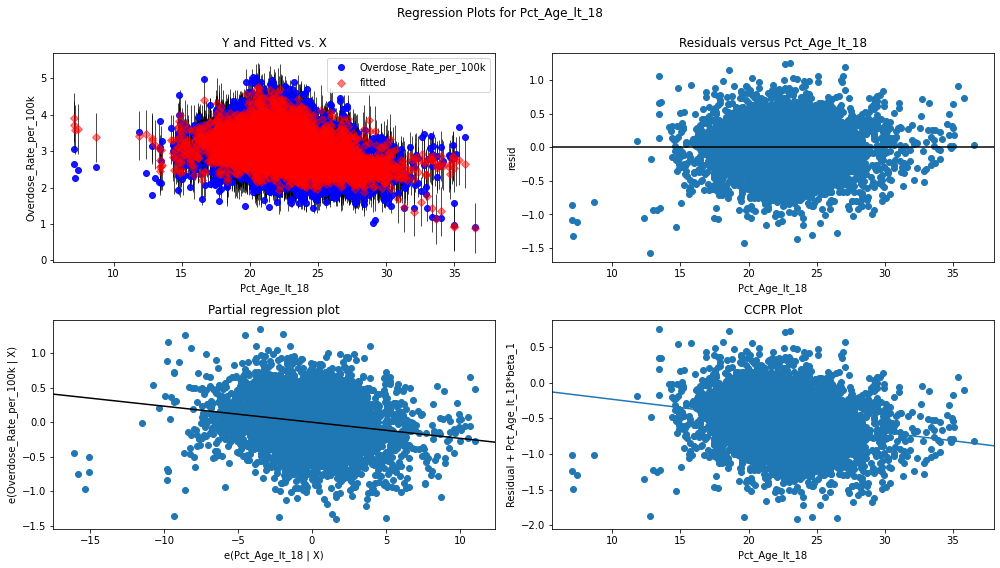

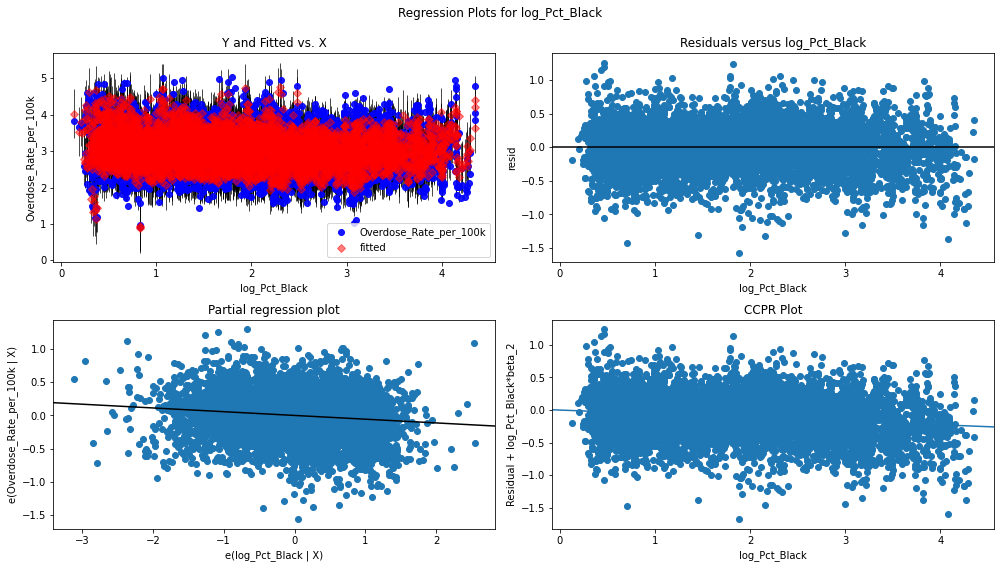

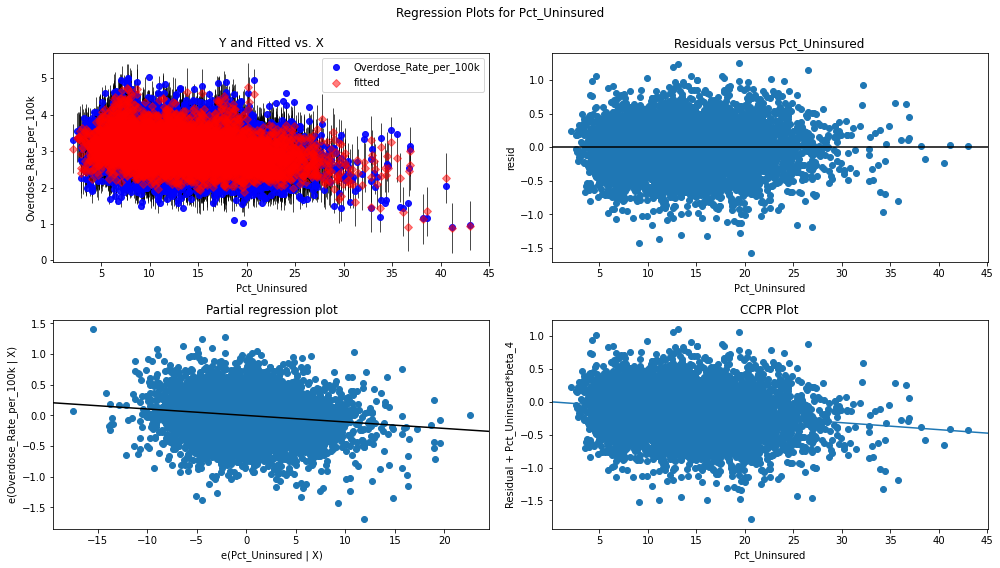

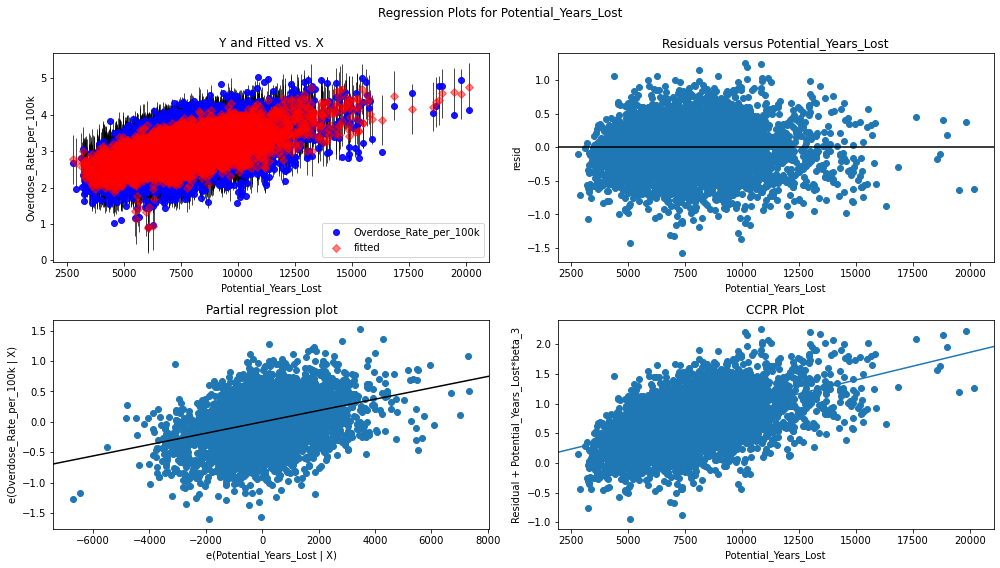

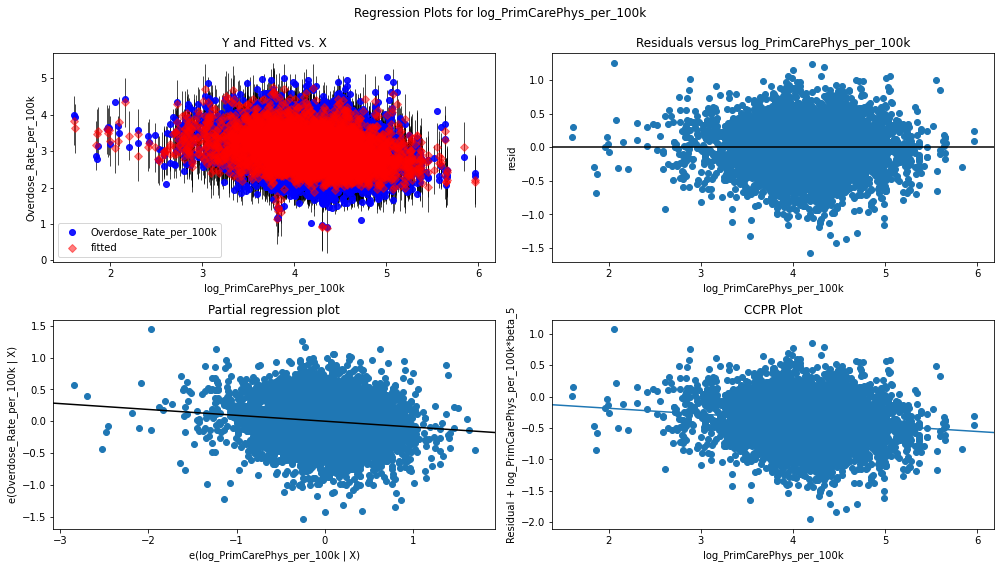

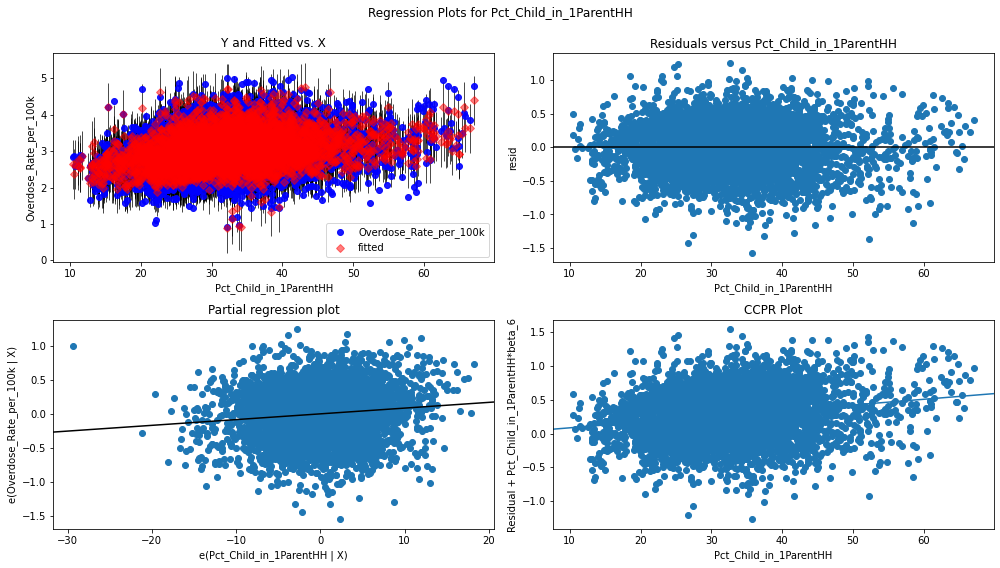

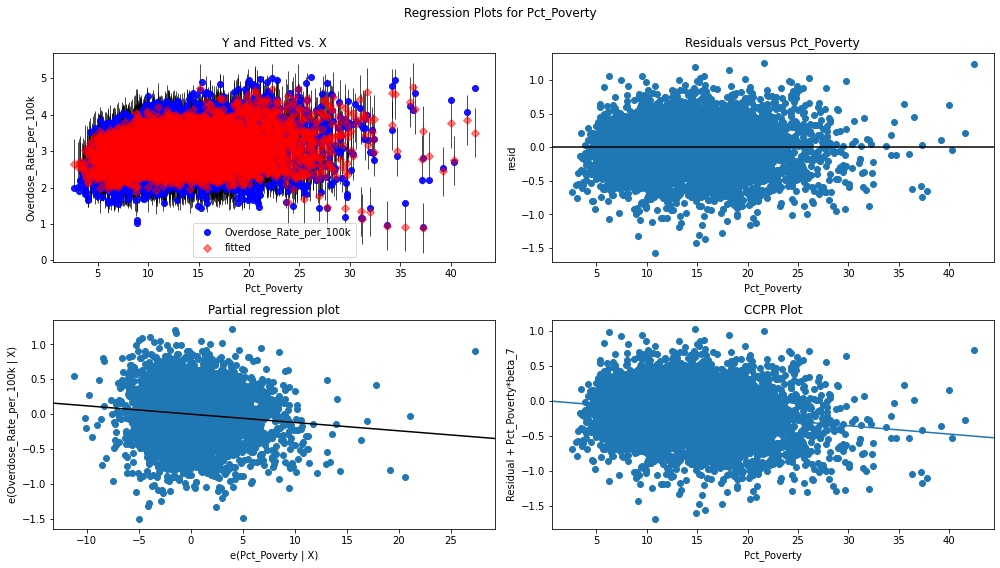

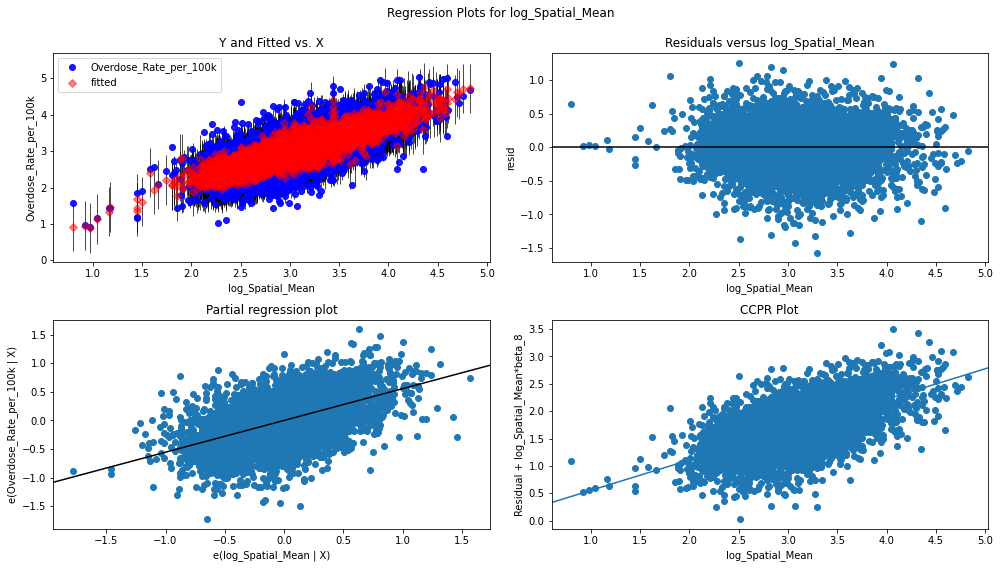

In [41]:
### Residual analysis with best subset 
# plot residuals
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

best_sub = ['Pct_Age_lt_18', 'log_Pct_Black', 'Pct_Uninsured', 'Potential_Years_Lost', 
            'log_PrimCarePhys_per_100k', 'Pct_Child_in_1ParentHH', 'Pct_Poverty', 'log_Spatial_Mean']
for i in best_sub: 
    fig = plt.figure(figsize=(14, 8))
    fig = sm.graphics.plot_regress_exog(res, i, fig=fig)

Residual plots look better!

### Get RMSE of final model 

In [63]:
od_model = od.copy()

In [65]:
od_model = od_model[["log_Overdose_Rate_per_100k",  'Pct_Age_lt_18', 'log_Pct_Black', 'Potential_Years_Lost', 'Pct_Uninsured',
                 'log_PrimCarePhys_per_100k', 'Pct_Child_in_1ParentHH', 'Pct_Poverty', 'log_Spatial_Mean']]
od_model

,log_Overdose_Rate_per_100k,Pct_Age_lt_18,log_Pct_Black,Potential_Years_Lost,Pct_Uninsured,log_PrimCarePhys_per_100k,Pct_Child_in_1ParentHH,Pct_Poverty,log_Spatial_Mean
0,2.553630,23.100000,2.397895,8321.800000,20.900000,4.794964,28.900000,13.4,3.075796
1,2.475265,23.400000,3.044522,11719.600000,15.600000,4.653008,38.200000,20.9,2.882247
2,2.519051,23.300000,0.993252,9564.700000,18.700000,4.347694,25.600000,18.2,3.538685
3,2.735118,25.500000,1.098612,9930.300000,21.100000,3.806662,29.200000,20.3,2.766661
4,3.737676,23.000000,3.499533,10843.400000,18.400000,4.347694,41.300000,25.5,2.573255
...,...,...,...,...,...,...,...,...,...
8013,3.123236,21.903856,0.808253,4820.302037,4.168638,4.003213,21.036707,5.1,3.373511
8014,3.173104,21.508564,0.951769,4812.293689,3.807879,4.931122,18.233691,4.2,3.355769
8015,3.097410,20.515144,1.153891,5939.367604,5.340179,4.386920,30.599278,8.7,2.996038
8016,3.211128,21.556362,0.631356,7032.122216,5.524299,4.995117,28.558645,9.4,2.334570


In [67]:
train_rmse_list = []
test_rmse_list = []
r2_test_list = []
r2_train_list = []

y = od_model[['log_Overdose_Rate_per_100k']]
X_int = od_model.drop('log_Overdose_Rate_per_100k', axis=1)
X_int.insert(0, 'Intercept', 1)

X = np.array(X_int)
y = np.array(y)

# Conduct 10-fold cross-validation so that we can get an average training and testing RMSE
kf = KFold(n_splits=10, random_state=0, shuffle=True)
for train_index, test_index in kf.split(od_model):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    mod = sm.OLS(y_train, x_train)
    res = mod.fit()
    
    y_train_pred = res.predict(x_train)
    r2_train_list.append(r2_score(y_train, y_train_pred))
    train_rmse_list.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    
    y_test_pred = res.predict(x_test)
    r2_test_list.append(r2_score(y_test, y_test_pred))
    test_rmse_list.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

score_board = pd.DataFrame(train_rmse_list, columns=['train_rmse'])
score_board['test_rmse'] = test_rmse_list
score_board.insert(0, 'r2_train', r2_train_list)
score_board.insert(1, 'r2_test', r2_test_list)
score_board

,r2_train,r2_test,train_rmse,test_rmse
0,0.623156,0.641864,0.343131,0.331782
1,0.623378,0.639102,0.341414,0.347385
2,0.624497,0.629928,0.341749,0.344400
3,0.624342,0.631351,0.342463,0.338022
4,0.621678,0.653500,0.342462,0.337903
5,0.625861,0.617876,0.341690,0.344912
6,0.628140,0.593392,0.342688,0.335899
7,0.625921,0.616378,0.342403,0.338696
8,0.628423,0.593087,0.340287,0.357494
9,0.626171,0.614995,0.341406,0.347546


In [55]:
# Normalized RMSE
0.34 / (max(y) - min(y))

array([0.07831516])

# Plotting Final Model Residuals on Map

`od_nonull.csv` can be found in `Reproducible` folder

In [175]:
od_nonull = pd.read_csv('od_nonull.csv')

In [49]:
# Fitting model so that we can calculate residuals after
y, X = dmatrices("Overdose_Rate_per_100k ~ Pct_Age_18 + log_Pct_Black + log_Potential_Years_Lost + \
  Pct_Uninsured + log_PrimCarePhys_per_100k + Pct_Child_in_1ParentHH + \
  log_Pct_Poverty + log_Prev_Spatial_Mean",
                 data=od_nonull, return_type='dataframe')

In [50]:
y = np.log(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=30)

In [51]:
# Final modeling 
mod = sm.OLS(y_train, x_train)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = od_y
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     Overdose_Rate_per_100k   R-squared:                       0.599
Model:                                OLS   Adj. R-squared:                  0.599
Method:                     Least Squares   F-statistic:                     1050.
Date:                    Sun, 01 May 2022   Prob (F-statistic):               0.00
Time:                            14:30:48   Log-Likelihood:                -2098.3
No. Observations:                    5622   AIC:                             4215.
Df Residuals:                        5613   BIC:                             4274.
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [63]:
y_pred_full = res.predict(X)

In [105]:
#putting the residuals in one column of a dataframe 
y = np.array(y).reshape(7497, 1)
y_pred_full = y_pred_full.reshape(7497,1)
resid = pd.DataFrame(y -  y_pred_full)
resid

,0
0,-0.277667
1,-0.635590
2,-0.754209
3,-0.153094
4,0.792528
...,...
7492,0.089783
7493,0.158608
7494,0.218754
7495,0.272947


In [174]:
#Append it top the whole dataframe 
od_nonull = od_nonull.reset_index(drop = True)
od_nonull['Residuals'] = resid

In [147]:
# Renaming columns
od_nonull = od_nonull.rename(columns={'Geometry':'geometry'})
od_nonull = od_nonull.rename(columns={'Pct_Age<18' : 'Pct_Age_18', 'Pct_Age>=65' : 'Pct_Age_65'})
od_nonull.dtypes

Year                           int64
FIPS                           int64
County                        object
State                         object
Region                        object
Division                      object
Overdose_Deaths              float64
Overdose_Pop                 float64
Overdose_Rate_per_100k       float64
Population                   float64
Pct_Age<18                   float64
Pct_Age>=65                  float64
Pct_Black                    float64
Pct_Native                   float64
Pct_Asian                    float64
Pct_Pacific_Islander         float64
Pct_Hispanic                 float64
Pct_Not_Prof_in_Eng          float64
Pct_Female                   float64
Pct_Rural                    float64
Pct_Diabetes                 float64
Potential_Years_Lost         float64
Pct_Low_Weight_Births        float64
Pct_Smokers                  float64
Pct_Adults_Obsese            float64
Pct_Excessive_Drinking       float64
Pct_DUI_Deaths               float64
T

In [153]:
import geopandas as gpd
import contextily as cx

In [149]:
from shapely import wkt

od_nonull['geometry'] = od_nonull['geometry'].apply(wkt.loads)
geo_od_nonull = gpd.GeoDataFrame(od_nonull, crs='epsg:4326')

In [ ]:
# Subsetting to Residual
df_2020 = od_nonull[od_nonull['Year']==2020]
df_2020 = df_2020.reset_index()

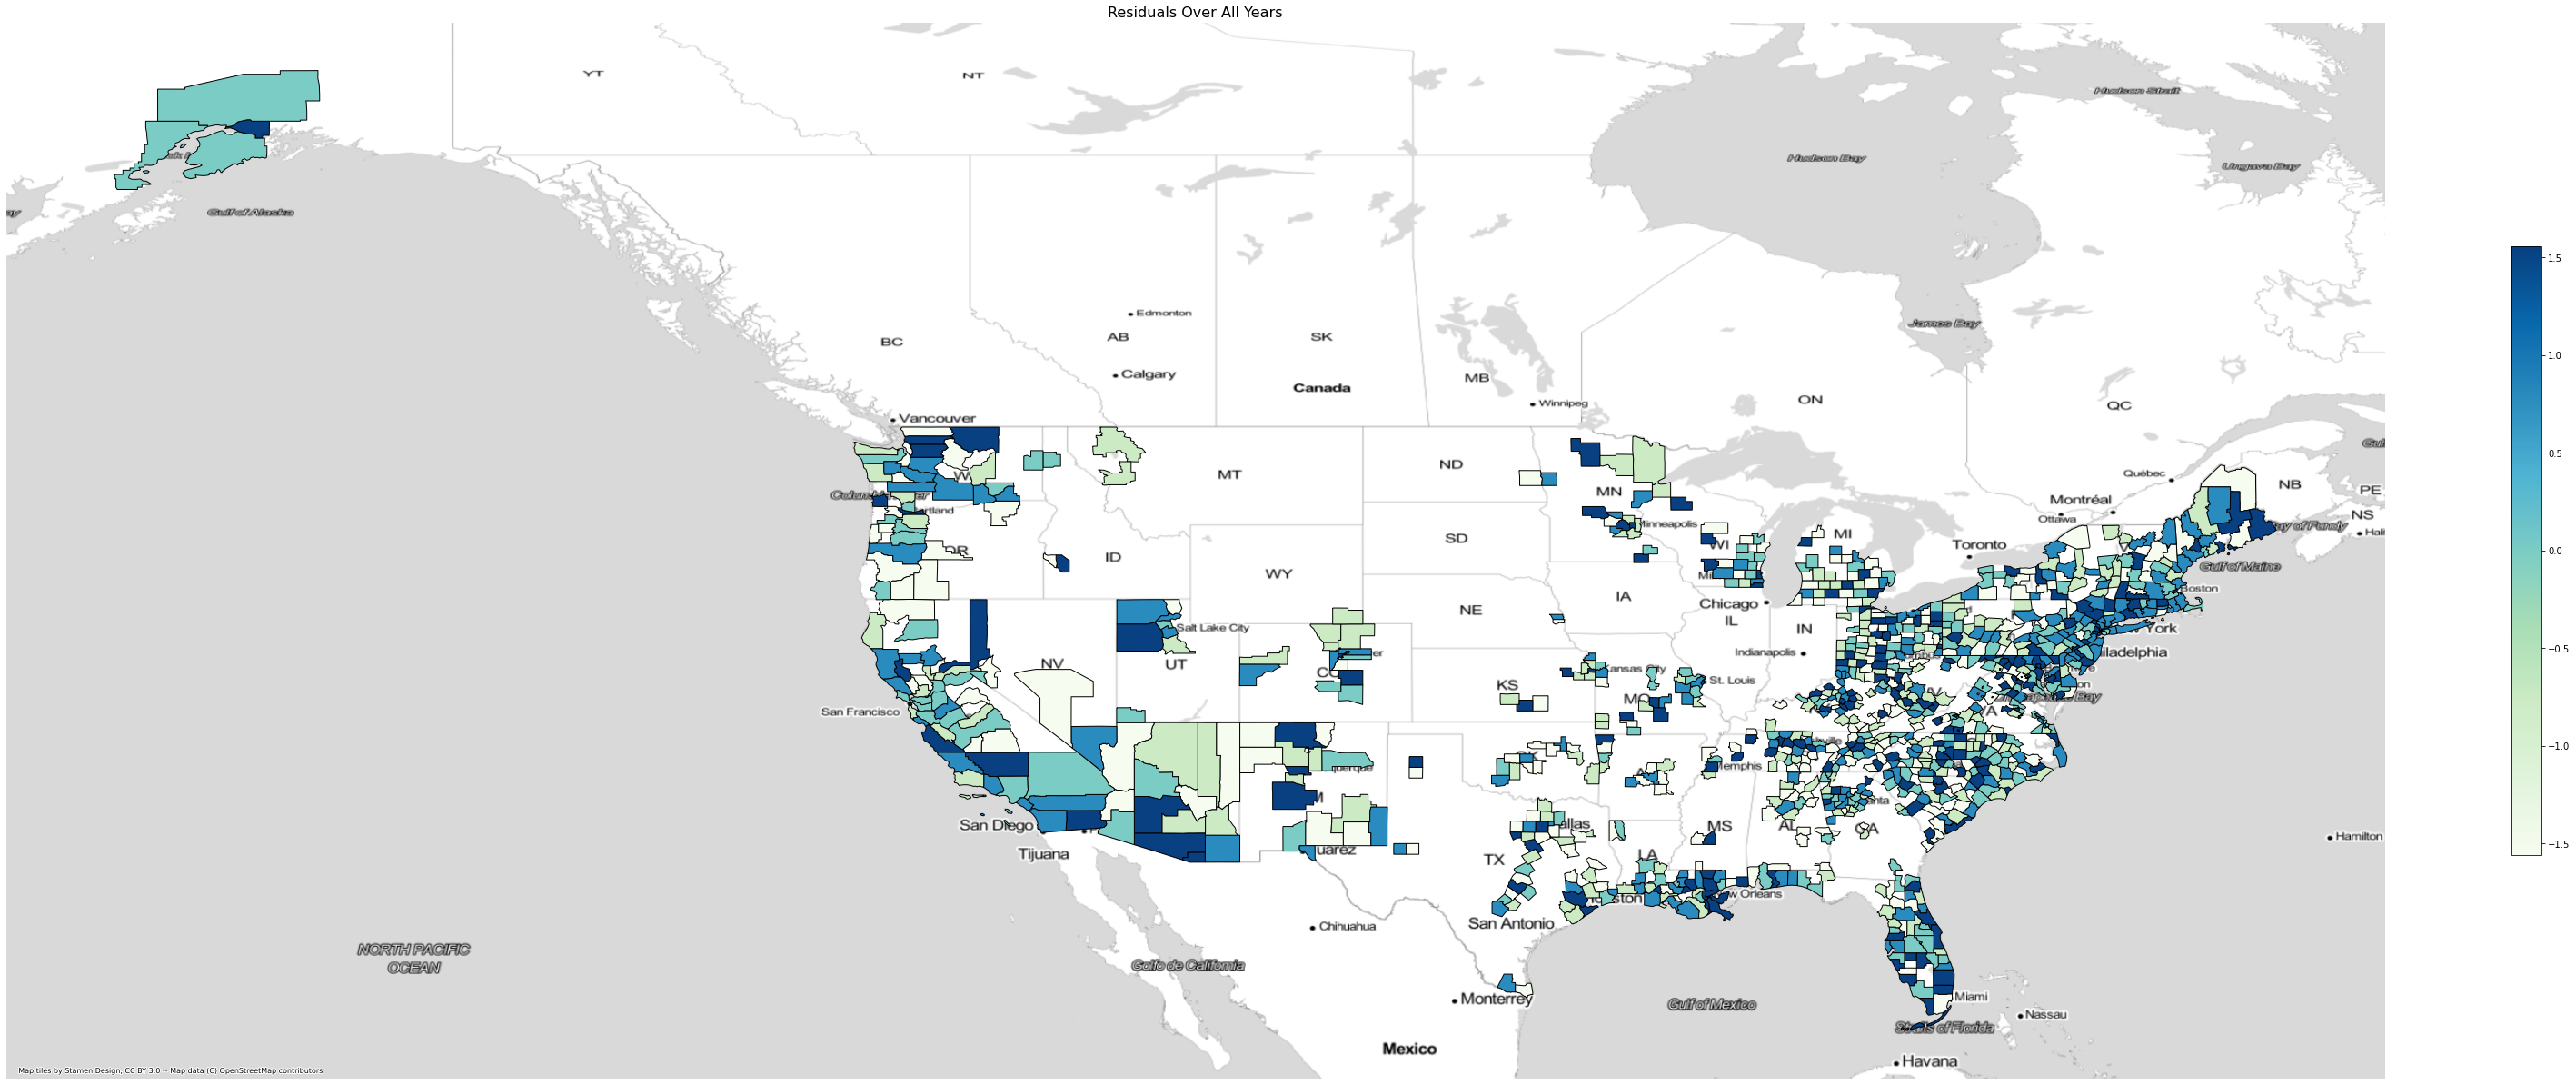

In [97]:
# Plotting residual on U.S. map for the year 2020

f,ax = plt.subplots(1,1,figsize=(50,50))

df_2020.plot(column='Residuals', ax=ax,
        scheme="quantiles",  k=5, cmap='GnBu',edgecolor='black')

ax.set_title("Residuals for Year 2020", fontsize=16)
ax.axis('off')

sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=minin, vmax=-minin))
sm.set_array = ([])
f.colorbar(sm, fraction=0.012)

cx.add_basemap(ax, crs=df_2020.crs.to_string(), source=cx.providers.Stamen.TonerLite)

plt.show()


f.savefig('graph.png')



The residuals seem to be scattered randomly throughout the map, so we have successfully accounted for the geospatial aspect in our model.